# DKASC_Alice_Springs深度神经网络-WDWDR

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import keras
import catboost as cb
from pandas import read_csv
from math import sqrt
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:472: FutureWarning: Passi

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto(allow_soft_placement = True)
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.5)
config.gpu_options.allow_growth = True
sess0 = tf.InteractiveSession(config = config)

In [3]:
print(os.getcwd()) # 打印当前工作目录

E:\Research Project\DKASC, Alice Springs


In [4]:
os.listdir(os.getcwd())

['.ipynb_checkpoints',
 '101-Site_DKA-WeatherStation',
 '96-Site_DKA-MasterMeter1',
 'Alice_SpringsLSTM.ipynb',
 'Alice_SpringsSVM.ipynb',
 'Alice_Springs_2016-2020',
 'Alice_Springs数据集筛选提取.ipynb',
 'Alice_Springs深度神经网络-WDWDR.ipynb',
 'Alice_Springs深度神经网络.ipynb',
 'Dataset',
 'Predict',
 'Program backups',
 'temp',
 '笔记.ipynb']

In [5]:
os.chdir("./Dataset/")

In [6]:
os.listdir()

['testdata.csv',
 'test_1A.csv',
 'traindata.csv',
 'train_1A.csv',
 '测试集8个站点.csv',
 '训练集8个站点.csv']

In [7]:
train = pd.read_csv('train_1A.csv')
test = pd.read_csv('test_1A.csv')

In [8]:
#查看输入数据维度
print(train.shape)
print(test.shape)

(69765, 14)
(13136, 14)


In [9]:
train.head(5)

,Year,Month,Day,Hour,Minutes,WTC,WRH,GHR,DHR,WD,WDR,RGT,RDT,1A Trina_power
0,2018,1,19,18,30,26.243799,50.889774,71.416481,67.523544,302.882996,3.6,65.268631,59.278999,0.318600
1,2018,1,19,18,35,26.641783,49.539795,77.177094,71.776718,246.312622,3.6,72.546944,63.134579,0.328800
2,2018,1,19,18,40,26.654078,53.414265,78.373489,69.008316,305.089630,3.6,76.711456,65.430550,0.334200
3,2018,1,19,18,45,26.439108,55.582245,78.022881,67.560181,259.662933,3.6,80.445709,66.812790,0.333133
4,2018,1,19,18,50,26.479477,56.173820,82.106972,73.004196,186.634705,3.6,83.035919,69.054459,0.332400


In [10]:
test.head(5)

,Year,Month,Day,Hour,Minutes,WTC,WRH,GHR,DHR,WD,WDR,RGT,RDT,1A Trina_power
0,2020,1,1,7,0,26.475155,26.081675,162.153366,56.253025,33.677536,0.0,89.188049,48.190262,1.355933
1,2020,1,1,7,5,26.830191,23.874067,184.131439,60.059135,33.177525,0.0,103.596741,51.176495,2.196533
2,2020,1,1,7,10,27.303818,22.543364,205.897934,63.810493,32.720444,0.0,120.530693,54.154552,1.468733
3,2020,1,1,7,15,27.597961,22.269592,225.959869,66.613937,32.253742,0.0,138.593536,56.979244,0.843667
4,2020,1,1,7,20,27.498199,21.532722,249.442825,70.428032,31.873810,0.0,160.114792,60.657581,1.005133


# 数据预处理训练集去异常值

In [11]:
#使用df.isnull().sum()来获得与行数None和NaN值。
train.isnull().sum()

Year              0
Month             0
Day               0
Hour              0
Minutes           0
WTC               0
WRH               0
GHR               0
DHR               0
WD                0
WDR               0
RGT               0
RDT               0
1A Trina_power    0
dtype: int64

In [12]:
test.isnull().sum()

Year              0
Month             0
Day               0
Hour              0
Minutes           0
WTC               0
WRH               0
GHR               0
DHR               0
WD                0
WDR               0
RGT               0
RDT               0
1A Trina_power    0
dtype: int64

In [13]:
# #训练集去掉全是空值的行和列    #axis=0, how='any', thresh=None, subset=None, inplace=False)
# # detectioncolumns=['WTC', 'WRH', 'GHR', 'DHR', 'WD', 'WDR', 'RGT', 'RDT']
# # for i in detectioncolumns:
# train.dropna(axis="index",how='any' , inplace=True)  #删除掉全是空值的行
# # train.dropna(axis="columns", how='all', inplace=True)  #删除掉全是空值的列


# test.dropna(axis="index", how='any', inplace=True)  #删除掉全是空值的行
# # test.dropna(axis="columns", how='all', inplace=True)  #删除掉全是空值的列

In [14]:
# #填补缺失值为均值
# #train.ffill({"RGT":train['RGT'].mean()})
# detectioncolumns=['WTC', 'WRH', 'GHR', 'DHR', 'WD', 'WDR', 'RGT', 'RDT']
# for i in detectioncolumns:
#     replace_NA=train[i].mean()
#     train[i].fillna(replace_NA,inplace=True)
# #去除测试集空值
# for i in detectioncolumns:
#     replace_NA=test[i].mean()
#     test[i].fillna(replace_NA,inplace=True)


In [15]:
train.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minutes', 'WTC', 'WRH', 'GHR', 'DHR',
       'WD', 'WDR', 'RGT', 'RDT', '1A Trina_power'],
      dtype='object')

In [16]:
test.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minutes', 'WTC', 'WRH', 'GHR', 'DHR',
       'WD', 'WDR', 'RGT', 'RDT', '1A Trina_power'],
      dtype='object')

In [17]:
train.head()

,Year,Month,Day,Hour,Minutes,WTC,WRH,GHR,DHR,WD,WDR,RGT,RDT,1A Trina_power
0,2018,1,19,18,30,26.243799,50.889774,71.416481,67.523544,302.882996,3.6,65.268631,59.278999,0.318600
1,2018,1,19,18,35,26.641783,49.539795,77.177094,71.776718,246.312622,3.6,72.546944,63.134579,0.328800
2,2018,1,19,18,40,26.654078,53.414265,78.373489,69.008316,305.089630,3.6,76.711456,65.430550,0.334200
3,2018,1,19,18,45,26.439108,55.582245,78.022881,67.560181,259.662933,3.6,80.445709,66.812790,0.333133
4,2018,1,19,18,50,26.479477,56.173820,82.106972,73.004196,186.634705,3.6,83.035919,69.054459,0.332400


In [18]:
test.head()

,Year,Month,Day,Hour,Minutes,WTC,WRH,GHR,DHR,WD,WDR,RGT,RDT,1A Trina_power
0,2020,1,1,7,0,26.475155,26.081675,162.153366,56.253025,33.677536,0.0,89.188049,48.190262,1.355933
1,2020,1,1,7,5,26.830191,23.874067,184.131439,60.059135,33.177525,0.0,103.596741,51.176495,2.196533
2,2020,1,1,7,10,27.303818,22.543364,205.897934,63.810493,32.720444,0.0,120.530693,54.154552,1.468733
3,2020,1,1,7,15,27.597961,22.269592,225.959869,66.613937,32.253742,0.0,138.593536,56.979244,0.843667
4,2020,1,1,7,20,27.498199,21.532722,249.442825,70.428032,31.873810,0.0,160.114792,60.657581,1.005133


# keras模型训练

准备数据

In [19]:
# train1=train[['Year','Month','Day', 'Hour',
#        'Minutes','WTC', 'WRH', 'GHR', 'DHR', 'WD', 'WDR', 'RGT', 'RDT', '1A Trina_power']]
# print("查看训练集\n",train1.head())
# test1=test[['Year','Month','Day', 'Hour',
#        'Minutes','WTC', 'WRH', 'GHR', 'DHR', 'WD', 'WDR', 'RGT', 'RDT', '1A Trina_power']]
# print("查看测试集\n",test.head())
############
#去除 WD，WDR 特征
train1=train[['Year','Month','Day', 'Hour',
       'Minutes','WTC', 'WRH', 'GHR', 'DHR', 'RGT', 'RDT', '1A Trina_power']]
print("查看训练集\n",train1.head())
test1=test[['Year','Month','Day', 'Hour',
       'Minutes','WTC', 'WRH', 'GHR', 'DHR','RGT', 'RDT', '1A Trina_power']]
print("查看测试集\n",test.head())


查看训练集
    Year  Month  Day  Hour  Minutes        WTC        WRH        GHR  \
0  2018      1   19    18       30  26.243799  50.889774  71.416481   
1  2018      1   19    18       35  26.641783  49.539795  77.177094   
2  2018      1   19    18       40  26.654078  53.414265  78.373489   
3  2018      1   19    18       45  26.439108  55.582245  78.022881   
4  2018      1   19    18       50  26.479477  56.173820  82.106972   

         DHR        RGT        RDT  1A Trina_power  
0  67.523544  65.268631  59.278999        0.318600  
1  71.776718  72.546944  63.134579        0.328800  
2  69.008316  76.711456  65.430550        0.334200  
3  67.560181  80.445709  66.812790        0.333133  
4  73.004196  83.035919  69.054459        0.332400  
查看测试集
    Year  Month  Day  Hour  Minutes        WTC        WRH         GHR  \
0  2020      1    1     7        0  26.475155  26.081675  162.153366   
1  2020      1    1     7        5  26.830191  23.874067  184.131439   
2  2020      1    1     7

归一化数据

In [20]:
train1 = train1.values
train1 = train1.astype('float32')     # 将整型变为float
scaler = MinMaxScaler(feature_range=(0, 1)) # 数据处理，归一化至0~1之间
train1 = scaler.fit_transform(train1)

test1 = test1.values
test1 = test1.astype('float32')     # 将整型变为float
scaler = MinMaxScaler(feature_range=(0, 1)) # 数据处理，归一化至0~1之间
test1 = scaler.fit_transform(test1)

inds = np.arange(train1.shape[0])
random.shuffle(inds)
train1_inds = inds[0:int(train1.shape[0]*0.8)]
eval1_inds = inds[int(train1.shape[0]*0.8):train1.shape[0]]

train_x, train_y = train1[train1_inds,1:-1], train1[train1_inds,-1:]
#############
train_year =train1[train1_inds,0:1]
##############
eval_x,eval_y = train1[eval1_inds,1:-1], train1[eval1_inds,-1:]
test_x, test_y = test1[:,1:-1], test1[:,-1:]
##############
test_year = test1[:,0:1]
##############

In [21]:
print(train1)

[[0.         0.         0.6        ... 0.05057754 0.16080084 0.03964721]
 [0.         0.         0.6        ... 0.0562432  0.17127295 0.04080353]
 [0.         0.         0.6        ... 0.05948498 0.17750902 0.0414157 ]
 ...
 [1.         1.         1.0000001  ... 0.03924772 0.11613394 0.04396261]
 [1.         1.         1.0000001  ... 0.03504231 0.10863898 0.05198879]
 [1.         1.         1.0000001  ... 0.0314142  0.09906423 0.03422841]]


In [22]:
print(train_x)

[[0.18181819 0.8333334  0.72727275 ... 0.21875627 0.55550474 0.2143512 ]
 [0.6363636  0.13333334 0.         ... 0.03119139 0.06487878 0.03226681]
 [1.         0.10000001 0.6363636  ... 0.26369604 0.7778821  0.20140827]
 ...
 [0.72727275 0.5        0.6363636  ... 0.22618344 0.8220678  0.26579157]
 [1.         0.96666664 0.         ... 0.3887734  0.12028668 0.31858137]
 [0.36363637 0.56666666 1.0000001  ... 0.00724374 0.00383908 0.00920231]]


In [23]:
print(train_y)

[[0.74321896]
 [0.00512028]
 [0.8362269 ]
 ...
 [0.4937499 ]
 [0.20206022]
 [0.0035294 ]]


In [24]:
print(train_year)

[[1.]
 [0.]
 [1.]
 ...
 [0.]
 [1.]
 [0.]]


In [25]:
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(55812, 10) (55812, 1) (13136, 10) (13136, 1)


# Model1

In [26]:
model1 = Sequential()
model1.add(Dense(units=64, input_shape = (10,),activation='softmax',name='layer1'))
model1.add(Dense(units=64,name='layer2'))
model1.add(Dense(units=16,name='layer3'))
model1.add(Dense(units=8,name='layer4'))
model1.add(Dense(units=1,name='layer5'))
model1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['mae'])
history = model1.fit(x = train_x,y = train_y, validation_data = (eval_x,eval_y), epochs=50, batch_size=1000,verbose=1)
######################################################################
#######################################################################

Train on 55812 samples, validate on 13953 samples
Epoch 1/50
55812/55812 [==============================] - 2s - loss: 0.0677 - mean_absolute_error: 0.2018 - val_loss: 0.0465 - val_mean_absolute_error: 0.1699
Epoch 2/50
55812/55812 [==============================] - 0s - loss: 0.0333 - mean_absolute_error: 0.1510 - val_loss: 0.0262 - val_mean_absolute_error: 0.1360
Epoch 3/50
55812/55812 [==============================] - 0s - loss: 0.0251 - mean_absolute_error: 0.1327 - val_loss: 0.0224 - val_mean_absolute_error: 0.1274
Epoch 4/50
55812/55812 [==============================] - 0s - loss: 0.0246 - mean_absolute_error: 0.1309 - val_loss: 0.0243 - val_mean_absolute_error: 0.1297
Epoch 5/50
55812/55812 [==============================] - 0s - loss: 0.0237 - mean_absolute_error: 0.1289 - val_loss: 0.0231 - val_mean_absolute_error: 0.1285
Epoch 6/50
55812/55812 [==============================] - 0s - loss: 0.0235 - mean_absolute_error: 0.1283 - val_loss: 0.0232 - val_mean_absolute_error: 0.1

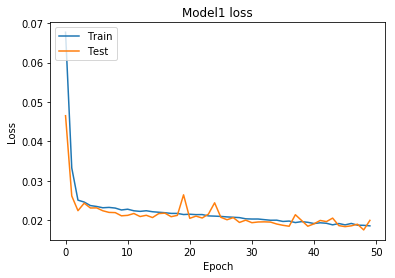

In [27]:
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [28]:
# # 绘制训练 & 验证的准确率值
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

#  Model2   Dense with activation

In [29]:
model2 = Sequential()
model2.add(Dense(units=64, input_shape = (10,),activation='sigmoid',name='layer1'))
model2.add(Dense(units=32, activation='sigmoid',name='layer2'))
model2.add(Dense(units=16,name='layer3',activation='sigmoid'))
model2.add(Dense(units=8,name='layer4',activation='sigmoid'))
model2.add(Dense(units=1,name='layer5'))
# model2.add(Dense(units=4,name='layer5',activation='sigmoid'))
# model2.add(Dense(units=1,name='layer6'))
model2.compile(loss='mean_absolute_error',
              optimizer='rmsprop',
              metrics=['mae'])
history=model2.fit(x = train_x,y = train_y, validation_data = (eval_x,eval_y), epochs=50, batch_size=1000)

#########################################################################


Train on 55812 samples, validate on 13953 samples
Epoch 1/50
55812/55812 [==============================] - 0s - loss: 0.3210 - mean_absolute_error: 0.3210 - val_loss: 0.1974 - val_mean_absolute_error: 0.1974
Epoch 2/50
55812/55812 [==============================] - 0s - loss: 0.1961 - mean_absolute_error: 0.1961 - val_loss: 0.1961 - val_mean_absolute_error: 0.1961
Epoch 3/50
55812/55812 [==============================] - 0s - loss: 0.1935 - mean_absolute_error: 0.1935 - val_loss: 0.1910 - val_mean_absolute_error: 0.1910
Epoch 4/50
55812/55812 [==============================] - 0s - loss: 0.1855 - mean_absolute_error: 0.1855 - val_loss: 0.1794 - val_mean_absolute_error: 0.1794
Epoch 5/50
55812/55812 [==============================] - 0s - loss: 0.1719 - mean_absolute_error: 0.1719 - val_loss: 0.1637 - val_mean_absolute_error: 0.1637
Epoch 6/50
55812/55812 [==============================] - 0s - loss: 0.1549 - mean_absolute_error: 0.1549 - val_loss: 0.1466 - val_mean_absolute_error: 0.1

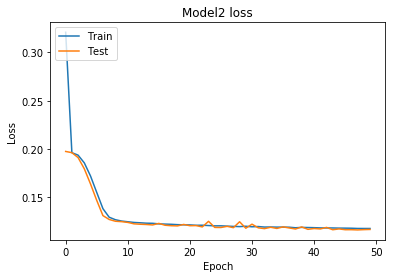

In [30]:
########################################################################
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# dense_model3 with activation,bias

In [31]:
model3 = Sequential()
model3.add(Dense(units=64, input_shape = (10,),activation='sigmoid',name='layer1',use_bias = True))
model3.add(Dense(units=32,activation='sigmoid',name='layer2',use_bias = True))
model3.add(Dense(units=16,name='layer3',activation='sigmoid',use_bias = True))
model3.add(Dense(units=8,name='layer4',activation='sigmoid',use_bias = True))
model3.add(Dense(units=1,name='layer5'))
model3.compile(loss='mean_absolute_error',
              optimizer='rmsprop',
              metrics=['mae'])
history=model3.fit(x = train_x,y = train_y, validation_data = (eval_x,eval_y), epochs=50, batch_size=1000)
############################################################################################################

Train on 55812 samples, validate on 13953 samples
Epoch 1/50
55812/55812 [==============================] - 0s - loss: 0.2178 - mean_absolute_error: 0.2178 - val_loss: 0.1960 - val_mean_absolute_error: 0.1960
Epoch 2/50
55812/55812 [==============================] - 0s - loss: 0.1939 - mean_absolute_error: 0.1939 - val_loss: 0.1923 - val_mean_absolute_error: 0.1923
Epoch 3/50
55812/55812 [==============================] - 0s - loss: 0.1892 - mean_absolute_error: 0.1892 - val_loss: 0.1859 - val_mean_absolute_error: 0.1859
Epoch 4/50
55812/55812 [==============================] - 0s - loss: 0.1811 - mean_absolute_error: 0.1811 - val_loss: 0.1749 - val_mean_absolute_error: 0.1749
Epoch 5/50
55812/55812 [==============================] - 0s - loss: 0.1679 - mean_absolute_error: 0.1679 - val_loss: 0.1612 - val_mean_absolute_error: 0.1612
Epoch 6/50
55812/55812 [==============================] - 0s - loss: 0.1516 - mean_absolute_error: 0.1516 - val_loss: 0.1423 - val_mean_absolute_error: 0.1

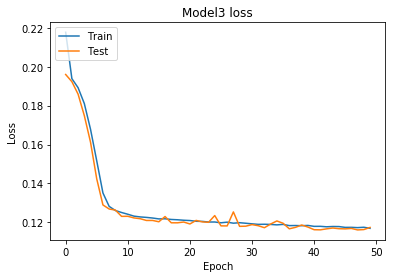

In [32]:
########################################################################
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# BP Model

In [57]:
model4=Sequential() #初始化模型
model4.add(Dense(10,input_shape = (10,),activation='sigmoid',init='uniform')) #添加一个隐含层，注：只是第一个隐含层需指定input_dim

model4.add(Dense(1,activation='sigmoid')) #添加输出层
model4.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['mae'])  # 编译，指定目标函数与优化方法
# model4.fit(train_x,train_y ) # 模型训练
history=model4.fit(x = train_x,y = train_y, validation_data = (eval_x,eval_y), epochs=50, batch_size=1000)
model4.evaluate(test_x,test_y) #模型测试

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_shape=(10,), activation="sigmoid", kernel_initializer="uniform")`
  


Train on 55812 samples, validate on 13953 samples
Epoch 1/50
55812/55812 [==============================] - 0s - loss: 0.7017 - mean_absolute_error: 0.2200 - val_loss: 0.6955 - val_mean_absolute_error: 0.2131
Epoch 2/50
55812/55812 [==============================] - 0s - loss: 0.6926 - mean_absolute_error: 0.2074 - val_loss: 0.6905 - val_mean_absolute_error: 0.2042
Epoch 3/50
55812/55812 [==============================] - 0s - loss: 0.6893 - mean_absolute_error: 0.2008 - val_loss: 0.6885 - val_mean_absolute_error: 0.1997
Epoch 4/50
55812/55812 [==============================] - 0s - loss: 0.6878 - mean_absolute_error: 0.1977 - val_loss: 0.6875 - val_mean_absolute_error: 0.1976
Epoch 5/50
55812/55812 [==============================] - 0s - loss: 0.6869 - mean_absolute_error: 0.1960 - val_loss: 0.6868 - val_mean_absolute_error: 0.1964
Epoch 6/50
55812/55812 [==============================] - 0s - loss: 0.6863 - mean_absolute_error: 0.1951 - val_loss: 0.6862 - val_mean_absolute_error: 0.1

[0.6685619663524279, 0.20548656266114598]

# 结果对比

In [58]:
#反归一化##
def inv(trainPredict,train_year,train_x,train_y):
    ######训练集#######
    inv_trainPredict = concatenate((train_year[:,:],train_x[:,:],trainPredict), axis=1)
    inv_trainPredict = scaler.inverse_transform(inv_trainPredict)
    trainPredict = inv_trainPredict[:,-1:]
    ###### 训练集真实值######
    train_y = train_y.reshape((len(train_y), 1))
    inv_train = concatenate((train_year[:,:],train_x[:,:],train_y), axis=1)
    inv_train = scaler.inverse_transform(inv_train)
    trainReal = inv_train[:,-1:]
    return trainPredict,trainReal   

In [59]:
trainPredictm4 = model4.predict(train_x)
testPredictm4 = model4.predict(test_x)

trainPredictm4,trainReal=inv(trainPredictm4,train_year,train_x,train_y)
testPredictm4,testReal=inv(testPredictm4,test_year,test_x,test_y)

In [60]:
### 模型 4
trainScorem4 = math.sqrt(mean_squared_error(trainReal[:,0], trainPredictm4[:,0]))
print('Model4 ')
print('Train Score: %.2f RMSE' % (trainScorem4))
testScorem4 = math.sqrt(mean_squared_error(testReal[:,0], testPredictm4[:,0]))
print('Test Score: %.2f RMSE' % (testScorem4))

Model4 
Train Score: 2.12 RMSE
Test Score: 2.18 RMSE


In [46]:
######### 模型 1 #########
###########预测训练集和测试集#######
trainPredictM1 = model1.predict(train_x)
testPredictM1 = model1.predict(test_x)
###### 反归一化 ########
######训练集 模型1 #######
inv_trainPredict1 = concatenate((train_year[:,:],train_x[:,:],trainPredictM1), axis=1)
inv_trainPredict1 = scaler.inverse_transform(inv_trainPredict1)
trainPredictM1 = inv_trainPredict1[:,-1:]

###### 训练集真实值######
train_y = train_y.reshape((len(train_y), 1))
inv_train = concatenate((train_year[:,:],train_x[:,:],train_y), axis=1)
inv_train = scaler.inverse_transform(inv_train)
trainReal = inv_train[:,-1:]

###### 测试预测模型1 #######
inv_testPredict1 = concatenate((test_year[:,:],test_x[:,:],testPredictM1), axis=1)
inv_testPredict1 = scaler.inverse_transform(inv_testPredict1)
testPredictM1 = inv_testPredict1[:,-1:]

########测试集真实值############
test_y = test_y.reshape((len(test_y), 1))
inv_test = concatenate((test_year[:,:],test_x[:,:],test_y), axis=1)
inv_test = scaler.inverse_transform(inv_test)
testReal = inv_test[:,-1:]

In [47]:
######### 模型 2 #########
#########预测训练集和测试集######
trainPredictM2 = model2.predict(train_x)
testPredictM2 = model2.predict(test_x)
####### 反归一化 ########
######训练集 模型2 #######
inv_trainPredict2 = concatenate((train_year[:,:],train_x[:,:],trainPredictM2), axis=1)
inv_trainPredict2 = scaler.inverse_transform(inv_trainPredict2)
trainPredictM2 = inv_trainPredict2[:,-1:]

###### 测试预测模型2 #######
inv_testPredict2 = concatenate((test_year[:,:],test_x[:,:],testPredictM2), axis=1)
inv_testPredict2 = scaler.inverse_transform(inv_testPredict2)
testPredictM2 = inv_testPredict2[:,-1:]


In [48]:
######### 模型 3 ##########
######预测训练集和测试集#########
trainPredictM3 = model3.predict(train_x)
testPredictM3 = model3.predict(test_x)
########## 反归一化 #########

######训练预测 模型3 #######
inv_trainPredict3 = concatenate((train_year[:,:],train_x[:,:],trainPredictM3), axis=1)
inv_trainPredict3 = scaler.inverse_transform(inv_trainPredict3)
trainPredictM3 = inv_trainPredict3[:,-1:]

###### 测试预测模型3 #######
inv_testPredict3 = concatenate((test_year[:,:],test_x[:,:],testPredictM3), axis=1)
inv_testPredict3 = scaler.inverse_transform(inv_testPredict3)
testPredictM3 = inv_testPredict3[:,-1:]

In [2]:
#评价指标
evaluate = pd.DataFrame(columns=['','SVM','BP','DNN','LSTM'])


NameError: name 'pd' is not defined

In [49]:
#################### 计算训练集和测试集的平均根方误差####################
### 模型 1
trainScoreM1 = math.sqrt(mean_squared_error(trainReal[:,0], trainPredictM1[:,0]))
print('Model1 ')
print('Train Score: %.2f RMSE' % (trainScoreM1))
testScoreM1 = math.sqrt(mean_squared_error(testReal[:,0], testPredictM1[:,0]))
print('Test Score: %.2f RMSE' % (testScoreM1))
### 模型 2
trainScoreM2 = math.sqrt(mean_squared_error(trainReal[:,0], trainPredictM2[:,0]))
print('Model2 ')
print('Train Score: %.2f RMSE' % (trainScoreM2))
testScoreM2 = math.sqrt(mean_squared_error(testReal[:,0], testPredictM2[:,0]))
print('Test Score: %.2f RMSE' % (testScoreM2))
### 模型 3
trainScoreM3 = math.sqrt(mean_squared_error(trainReal[:,0], trainPredictM3[:,0]))
print('Model3 ')
print('Train Score: %.2f RMSE' % (trainScoreM3))
testScoreM3 = math.sqrt(mean_squared_error(testReal[:,0], testPredictM3[:,0]))
print('Test Score: %.2f RMSE' % (testScoreM3))

Model1 
Train Score: 1.31 RMSE
Test Score: 1.69 RMSE
Model2 
Train Score: 1.37 RMSE
Test Score: 1.90 RMSE
Model3 
Train Score: 1.37 RMSE
Test Score: 1.89 RMSE


In [1]:
testScoreM=mean_absolute_error(testReal[:,0], testPredictM1)

NameError: name 'mean_absolute_error' is not defined

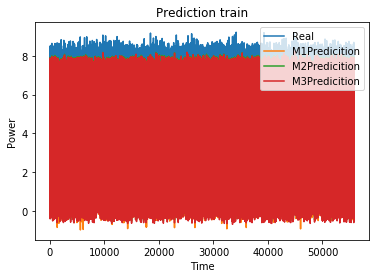

In [50]:
#训练集和测试集 预测结果保存
predict_train_1A = pd.DataFrame(inv_train)
predict_train_1A.columns = ['Year', 'Month', 'Day', 'Hour', 'Minutes', 'WTC', 'WRH', 'GHR', 'DHR',
       'RGT', 'RDT', '1A Trina_power']

predict_train_1A['1A_model1_predict'] = trainPredictM1
predict_train_1A['1A_model2_predict'] = trainPredictM2
predict_train_1A['1A_model3_predict'] = trainPredictM3

predict_train_1A.to_csv('../predict/predict_train_1A-WDWDR.csv',index=False)
#真实值和预测值对比图
plt.plot(trainReal,label='Real')
plt.plot(trainPredictM1,label='M1Predicition')
plt.plot(trainPredictM2,label='M2Predicition')
plt.plot(trainPredictM3,label='M3Predicition')

plt.title('Prediction train')
plt.ylabel('Power')
plt.xlabel('Time')
# plt.plot(y_rr_,label='rr')
# plt.plot(y_lasso_,label='lasso')
plt.legend() 

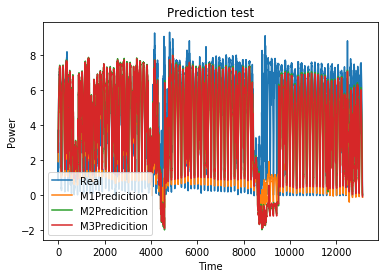

In [51]:
#训练集和测试集 预测结果保存
predict_1A = pd.DataFrame(inv_test)
predict_1A.columns = ['Year', 'Month', 'Day', 'Hour', 'Minutes', 'WTC', 'WRH', 'GHR', 'DHR',
       'RGT', 'RDT', '1A Trina_power']

predict_1A['1A_model1_predict'] = testPredictM1
predict_1A['1A_model2_predict'] = testPredictM2
predict_1A['1A_model3_predict'] = testPredictM3

predict_1A.to_csv('../predict/predict_1A-WDWDR.csv',index=False)
#真实值和预测值对比图
plt.plot(testReal,label='Real')
plt.plot(testPredictM1,label='M1Predicition')
plt.plot(testPredictM2,label='M2Predicition')
plt.plot(testPredictM3,label='M3Predicition')

plt.title('Prediction test')
plt.ylabel('Power')
plt.xlabel('Time')
# plt.plot(y_rr_,label='rr')
# plt.plot(y_lasso_,label='lasso')
plt.legend() 

In [52]:
# mse_test=np.sum((test_y - testPredict)**2)/ len(test_y)
# rmse_test=np.sqrt(mse_test)
# print("MSE:",mse_test)
# print("RMSE:",rmse_test)

画出例如2020年1月20号的预测图

In [ ]:
predict_1A.columns

In [ ]:
# from scipy.interpolate import spline
 
# # T = np.array([6, 7, 8, 9, 10, 11, 12])
# T=Day0120['Hour']
# T=T.values
# # power = np.array([1.53E+03, 5.92E+02, 2.04E+02, 7.24E+01, 2.72E+01, 1.10E+01, 4.70E+00])
# Real=Day0120.set_index('Hour', inplace=False)['1A Trina_power']
# Real=Real.values
# xnew = np.linspace(T.min(),T.max(),300) #300 represents number of points to make between T.min and T.max
 
# power_smooth = spline(T,Real,xnew)
 
# plt.plot(xnew,power_smooth)
# plt.show()

In [ ]:
# from scipy.interpolate import spline
predict_1A[["Year","Month","Day","Hour","Minutes"]] = predict_1A[["Year","Month","Day","Hour","Minutes"]].astype("int")

#real_power_day = train_1.groupby('day')
# Day0120 = predict_1A[(predict_1A['Year'] == 2020) & (predict_1A['Month'] == 1) & (predict_1A['Day'] == 20)]
# day200120 = predict_1A.loc[predict_1A['Year'] == '2020',predict_1A['Month'] == '1',predict_1A['day'] == '20',:]
Day0120 = predict_1A.loc[(predict_1A['Year'] == 2020) & (predict_1A['Month'] == 1) & (predict_1A['Day'] == 20),:]
#real_power_day.set_index('time', inplace=False)
Real=Day0120.set_index('Hour', inplace=False)['1A Trina_power']
M1Predict=Day0120.set_index('Hour', inplace=False)['1A_model1_predict']
M2Predict=Day0120.set_index('Hour', inplace=False)['1A_model2_predict']
M3Predict=Day0120.set_index('Hour', inplace=False)['1A_model3_predict']

fig = plt.figure()
plt.plot(Real,label='Real')
plt.plot(M1Predict,label='M1Predicition')
plt.plot(M2Predict,label='M2Predicition')
plt.plot(M3Predict,label='M3Predicition')

plt.title('Prediction 2020-1-20')
plt.ylabel('Power')
plt.xlabel('Time')
# plt.legend(['Train', 'Test'], loc='upper left')
plt.legend()
#ax = fig.add_subplot(1,1,1)
#ax.plot(real_power_day_)
# real_power_day_.plot()
#real_power_day_.set_axis(['00:15:00','06:15:00','12:15:00','18:15:00'])
#real_power_day_

In [ ]:
mse_test1=np.sum((trainReal[:,0] - trainPredictM1[:,0])**2)/ len(trainPredictM1)
print('MSE',mse_test1)

In [ ]:
rmse_test1=math.sqrt(mse_test1)
print('RMSE',rmse_test1)

In [ ]:
# trainScoreM1 = math.sqrt(mean_squared_error(trainReal[:,0], trainPredictM1[:,0]))